In [53]:
import pulp
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


doing some data preprocessing

In [38]:
prices_df = pd.read_csv("Data/GBCentralAllComplete_Prices.csv")
prices_df = prices_df.drop(columns=['Unnamed: 0', 'WeatherYear', 'Year'], errors='ignore') #getting rid of unneccesary columns
prices_df['Date'] = pd.to_datetime(prices_df['Date']) #making sure Date is correct format
prices_df = prices_df.set_index('Date')



In [42]:
prices_df = prices_df.head(96)

Formulating the pulp problem (only for day ahead)

In [47]:
time_steps = prices_df.index
day_ahead_prices = prices_df['DayAhead'].to_dict()

#defining the parameters
T = len(prices_df)
dt = 0.5 # 30 minute intervals
battery_capacity = 20
p_max = 10
rte = 0.9 #round-trip efficiency 
soc_min = 0.1 * battery_capacity
soc_max = 0.9 * battery_capacity
soc_initial = 0.5 * battery_capacity

#defining the problem
prob = pulp.LpProblem("BESS_Optimisation", pulp.LpMaximize)

#defining the variables
charge = pulp.LpVariable.dicts("charge", time_steps, lowBound=0, upBound=p_max, cat='Continuous')
discharge = pulp.LpVariable.dicts("dicharge", time_steps, lowBound=0, upBound=p_max, cat='Continuous')
soc = pulp.LpVariable.dicts("soc", time_steps, lowBound=soc_min, upBound=soc_max, cat='Continuous')
is_charging = pulp.LpVariable.dicts("is_charging", time_steps, cat='Binary')
is_discharging = pulp.LpVariable.dicts("is_discharging", time_steps, cat='Binary')
big_M = 1000

#objective function: maximise profit
prob += pulp.lpSum(
    (discharge[t] * day_ahead_prices[t] * dt) - (charge[t] * day_ahead_prices[t] * dt) 
    for t in time_steps
)

#constraints
for t in time_steps:
    #power limits
    prob += charge[t] <= p_max, f"Max_Charge_Power_{t}"
    prob += discharge[t] <= p_max, f"Max_Discharge_Power_{t}"
    
    #mutual exclusivity
    prob += charge[t] <= is_charging[t] * big_M, f"Charge_Exclusive_{t}"
    prob += discharge[t] <= is_discharging[t] * big_M, f"Discharge_Exclusive_{t}"
    prob += is_charging[t] + is_discharging[t] <= 1, f"Charging Status_{t}"

    # Energy balance
    if t == time_steps[0]:
        prob += soc[t] == soc_initial + (charge[t] * rte * dt) - (discharge[t] / rte * dt), f"Energy_Balance_{t}"
    else:
        prev_t = time_steps[prices_df.index.get_loc(t) - 1]
        prob += soc[t] == soc[prev_t] + (charge[t] * rte * dt) - (discharge[t] / rte * dt), f"Energy_Balance_{t}"

prob.solve()


Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Users/rajvirthind/University Work/MastersFinalProject/.venv/lib/python3.13/site-packages/pulp/apis/../solverdir/cbc/osx/i64/cbc /var/folders/16/z78kgyr52517f7j445ngztrh0000gn/T/3b02edd6c6594bf6839d35ca077103a5-pulp.mps -max -timeMode elapsed -branch -printingOptions all -solution /var/folders/16/z78kgyr52517f7j445ngztrh0000gn/T/3b02edd6c6594bf6839d35ca077103a5-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 581 COLUMNS
At line 2309 RHS
At line 2886 BOUNDS
At line 3463 ENDATA
Problem MODEL has 576 rows, 480 columns and 1151 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 3297.67 - 0.00 seconds
Cgl0004I processed model has 383 rows, 478 columns (192 integer (192 of which binary)) and 956 elements
Cbc0038I Initial state - 65 integers unsatisfied sum - 22.9903
Cbc0038I Pass   1: suminf.    0.0

1

In [58]:
if pulp.LpStatus[prob.status] == 'Optimal':
    print("Solution Found, Extracting Results")
    results_df = pd.DataFrame(index=time_steps) #creating dataframe to hold results

    results_df['charge'] = [charge[t].varValue for t in time_steps]
    results_df['discharge'] = [discharge[t].varValue for t in time_steps]
    results_df['soc'] = [soc[t].varValue for t in time_steps]

    results_df['profit'] = (results_df['discharge'] * prices_df['DayAhead'] * dt) - \
                          (results_df['charge'] * prices_df['DayAhead'] * dt)
    
    print("Results extracted successfully!")
else:
    print("No optimal solution found.")



Solution Found, Extracting Results
Results extracted successfully!


In [59]:
results_df

,charge,discharge,soc,profit
Date,,,,
2024-01-01 00:00:00,0.0,4.4,7.555556,0.018716
2024-01-01 00:30:00,0.0,10.0,2.000000,0.042536
2024-01-01 01:00:00,0.0,0.0,2.000000,0.000000
2024-01-01 01:30:00,0.0,0.0,2.000000,0.000000
2024-01-01 02:00:00,10.0,0.0,6.500000,42.451390
...,...,...,...,...
2024-01-02 21:30:00,0.0,0.0,2.000000,0.000000
2024-01-02 22:00:00,0.0,0.0,2.000000,0.000000
2024-01-02 22:30:00,0.0,0.0,2.000000,0.000000


<Axes: xlabel='Date'>

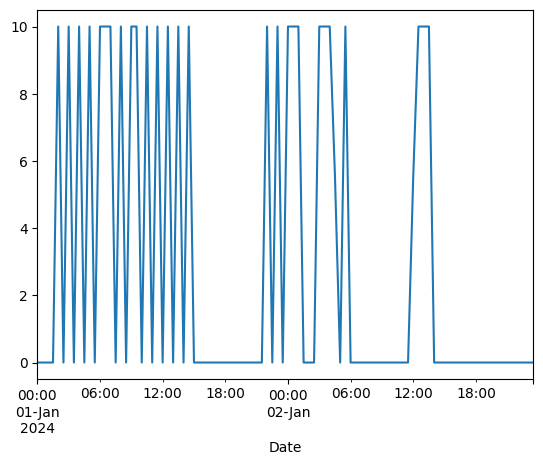

In [62]:
results_df.charge.plot()

<Axes: xlabel='Date'>

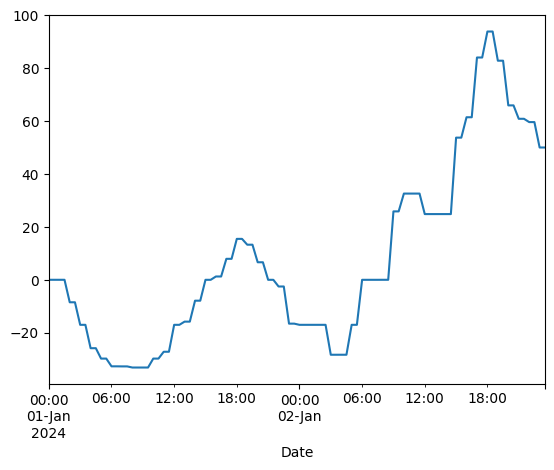

In [63]:
prices_df.DayAhead.plot()